### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

import seaborn as sns
%matplotlib inline

### Loading in the data

In [4]:
#Loading in the raw data
raw_training_data = pd.read_csv("training_data.csv")
raw_songs_to_classify = pd.read_csv("songs_to_classify.csv")

#Adding dummy variables for the categorical columns: Time Signiture, Key and mode
training_data = pd.get_dummies(data=raw_training_data,columns=['time_signature','key','mode'])
songs_to_classify = pd.get_dummies(data=raw_songs_to_classify,columns=['time_signature','key','mode'])

#Dividing training data into X and y where X contains all columns but the label and y contains only the label
X = training_data.drop('label',axis=1)
y = training_data['label']

#Dividing raw training data into X and y
X_raw = raw_training_data.drop('label',axis=1)
y_raw = raw_training_data['label']

#Displaying first five rows in X
X_raw.head()


,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.8850,0.366,352000,0.139,0.913000,7,0.0725,-19.978,1,0.0390,139.478,4,0.310
1,0.1240,0.863,236293,0.576,0.000000,5,0.1430,-5.687,0,0.2390,132.054,4,0.832
2,0.1840,0.631,219160,0.699,0.000000,9,0.1080,-7.625,0,0.0284,128.433,4,0.707
3,0.0108,0.800,201840,0.894,0.437000,6,0.0285,-7.346,0,0.0400,138.480,4,0.967
4,0.0044,0.788,228000,0.673,0.000005,9,0.0755,-9.232,1,0.1990,99.979,4,0.478


### Exploratory Data Analysis

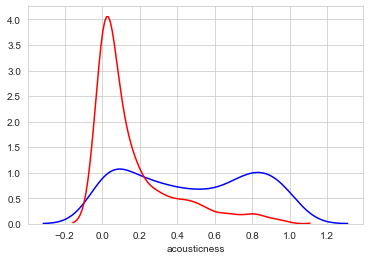

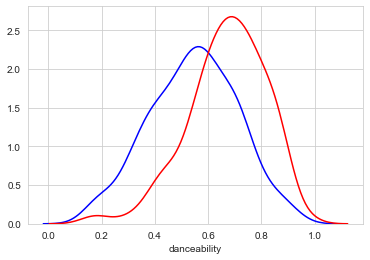

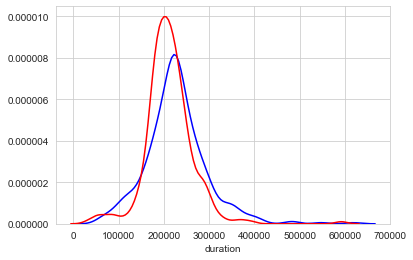

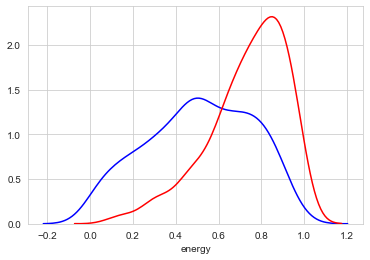

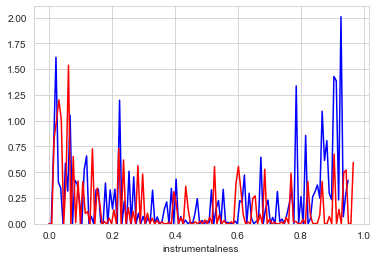

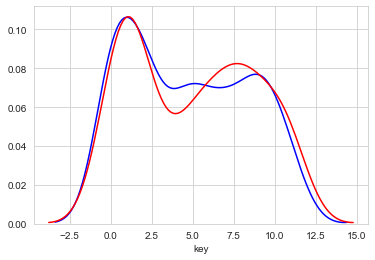

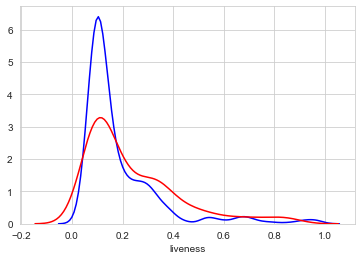

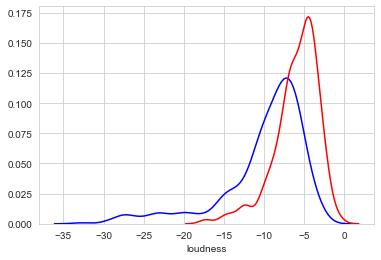

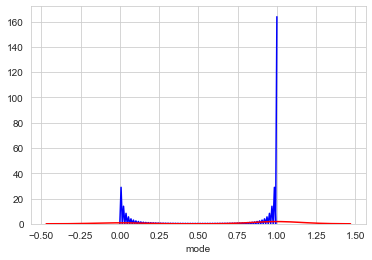

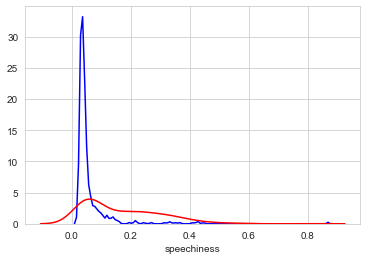

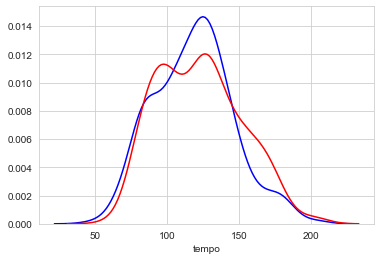

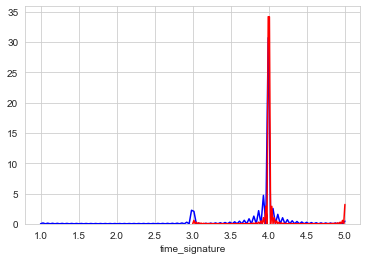

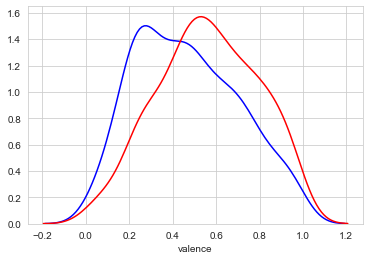

In [5]:
#Exploratory data analysis, plotting distribution curves for the features for disliked and liked songs

like_data =  raw_training_data[ raw_training_data['label']==1]
dislike_data =  raw_training_data[raw_training_data['label']==0]

column_list = ['acousticness',
 'danceability',
 'duration',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
'mode',
 'speechiness',
 'tempo',
 'time_signature',
 'valence']

sns.set_style("whitegrid")

for i in column_list:
    plt.figure()
    dist_plot_1 = sns.distplot(like_data[i],hist=False,color='blue')
    dist_plot_2 = sns.distplot(dislike_data[i],hist=False,color='red')


### Cross-validation for model selection using scikit-learn's KFold

0.78
0.8253333333333334
0.8159999999999998


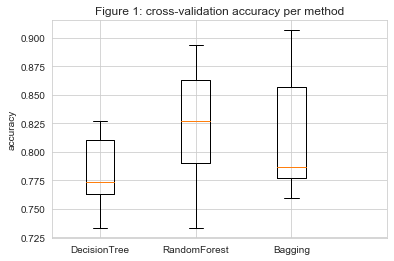

In [26]:
# Using scikit-learn's KFold to get cross-validation scores for the three types of tree based models.
# Their accuracy scores (the percentage of correct predictions) are plotted with a boxplot to determine which tree model 
# method performs the best

n_fold = 10

models = []
models.append(DecisionTreeClassifier(criterion='gini',random_state=42))
models.append(RandomForestClassifier(n_estimators=100, criterion='gini',random_state=42))
models.append(BaggingClassifier(random_state=42))

misclassifications = np.zeros((n_fold,len(models)))
cv = KFold(n_splits=n_fold,random_state=42, shuffle=True)

for i, (train_index,val_index) in enumerate(cv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    for m in range(np.shape(models)[0]):
        model = models[m]
        model.fit(X_train,y_train)
        predictions = model.predict(X_val)
        misclassifications[i,m] = np.mean(predictions == y_val)

for j in range(len(models)):
    print(np.mean(misclassifications[:,j]))

plt.boxplot(misclassifications)
plt.title('Figure 1: cross-validation accuracy per method');
plt.ylabel('accuracy')
plt.xticks(np.arange(4)+1,('DecisionTree','RandomForest','Bagging'))
plt.show()


### First initial Random Forest Classifier Model

In [27]:
# Using KFold to get cross-validation scores of a initial naive Random Forest Classifier using 
# n_estimators = 100 and criterion='gini'.

n_fold=10
misclassifications = np.zeros((n_fold,1))
cv = KFold(n_splits=n_fold,random_state=42, shuffle=True)

for i, (train_index,val_index) in enumerate(cv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model = RandomForestClassifier(n_estimators=100, criterion='gini',random_state=1)
    model.fit(X_train,y_train)
    predictions = model.predict(X_val)
    misclassifications[i] = np.mean(predictions == y_val)


print(np.mean(misclassifications))

0.8239999999999998


### KFold Cross-validation for parameter choices: Number of trees

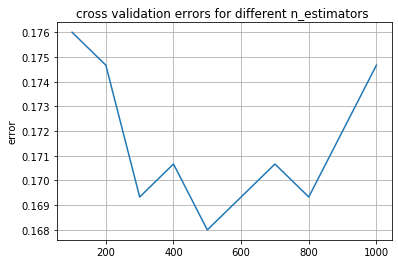

In [3]:
# Using scikit-learn's KFold to get cross-validation scores for different number of estimators in RFC-model

n_fold = 10
models = []
averages = []

for j in range(100,1100,100):
    models.append(RandomForestClassifier(n_estimators=j, random_state=1))


misclassifications = np.zeros((n_fold,len(models)))
cv = KFold(n_splits=n_fold,random_state=42, shuffle=True)

for i, (train_index,val_index) in enumerate(cv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    for m in range(np.shape(models)[0]):
        model = models[m]
        model.fit(X_train,y_train)
        predictions = model.predict(X_val)
        misclassifications[i,m] = np.mean(predictions != y_val)

for j in range(len(models)):
    #print(np.mean(misclassifications[:,j]))
    averages.append(np.mean(misclassifications[:,j]))

plt.plot(range(100,1100,100),averages)
plt.title('Figure 2: cross-validation errors for different n_estimators ');
plt.ylabel('error')
plt.grid()
plt.show()



### KFold Cross-validation for parameter choices: Criterion

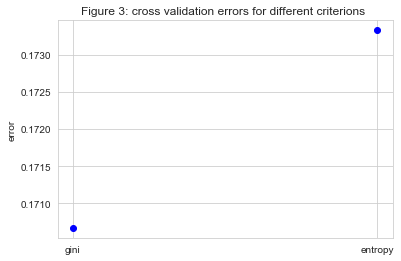

In [28]:
# Using scikit-learn's KFold to get cross-validation scores for different number of criterions in RFC-model

n_fold = 10
models = []
averages = []
criterions = ['gini','entropy']

for j in criterions:
    models.append(RandomForestClassifier(criterion=j, random_state=42))


misclassifications = np.zeros((n_fold,len(models)))
cv = KFold(n_splits=n_fold,random_state=42, shuffle=True)

for i, (train_index,val_index) in enumerate(cv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    for m in range(np.shape(models)[0]):
        model = models[m]
        model.fit(X_train,y_train)
        predictions = model.predict(X_val)
        misclassifications[i,m] = np.mean(predictions != y_val)

for j in range(len(models)):
    #print(np.mean(misclassifications[:,j]))
    averages.append(np.mean(misclassifications[:,j]))

plt.plot(criterions,averages,'bo')
plt.title('Figure 3: cross validation errors for different criterions ');
plt.ylabel('error')
plt.grid(b=True)
plt.show()



### KFold Cross-validation for parameter choices: max_features

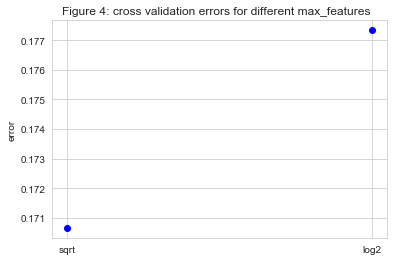

In [29]:
# Using scikit-learn's KFold to get cross-validation scores for different 'max_features' values

n_fold = 10
models = []
averages = []
max_features = ['sqrt','log2']

for j in max_features:
    models.append(RandomForestClassifier(max_features=j, random_state=42))


misclassifications = np.zeros((n_fold,len(models)))
cv = KFold(n_splits=n_fold,random_state=42, shuffle=True)

for i, (train_index,val_index) in enumerate(cv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    for m in range(np.shape(models)[0]):
        model = models[m]
        model.fit(X_train,y_train)
        predictions = model.predict(X_val)
        misclassifications[i,m] = np.mean(predictions != y_val)

for j in range(len(models)):
    averages.append(np.mean(misclassifications[:,j]))

plt.plot(max_features,averages,'bo')
plt.title('Figure 4: cross validation errors for different max_features  ');
plt.ylabel('error')
plt.grid(b=True)
plt.show()



### KFold Cross-validation for parameter choices: max_depth

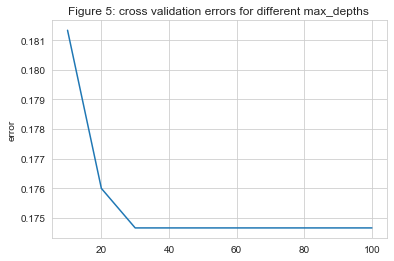

In [46]:
# Using scikit-learn's KFold to get cross-validation scores for different number of max_depth (The maximum depth of the tree) in RFC-model

n_fold = 10
models = []
averages = []
max_depth_list = list(range(10,110,10))
max_depth_list.append(None)

for j in max_depth_list:
    models.append(RandomForestClassifier(max_depth=j,random_state=42))


misclassifications = np.zeros((n_fold,len(models)))
cv = KFold(n_splits=n_fold,random_state=42, shuffle=True)

for i, (train_index,val_index) in enumerate(cv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    for m in range(np.shape(models)[0]):
        model = models[m]
        model.fit(X_train,y_train)
        predictions = model.predict(X_val)
        misclassifications[i,m] = np.mean(predictions != y_val)

for j in range(len(models)):
    #print(np.mean(misclassifications[:,j]))
    averages.append(np.mean(misclassifications[:,j]))

plt.plot(max_depth_list,averages)
plt.title('Figure 5: cross validation errors for different max_depths ');
plt.ylabel('error')
plt.grid(b=True)
plt.show()



### KFold Cross-validation for parameter choices: min_samples_split

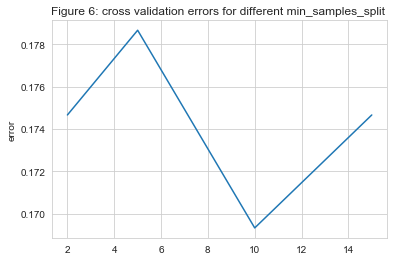

In [38]:
# Using scikit-learn's KFold to get cross-validation scores for different min_samples_split 
# (the minimum number of samples required to split an internal node) values in RFC-model

n_fold = 10
models = []
averages = []
min_samples_split_list = [2,5,10,15]

for j in min_samples_split_list:
    models.append(RandomForestClassifier(min_samples_split=j,random_state=42))


misclassifications = np.zeros((n_fold,len(models)))
cv = KFold(n_splits=n_fold,random_state=42, shuffle=True)

for i, (train_index,val_index) in enumerate(cv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    for m in range(np.shape(models)[0]):
        model = models[m]
        model.fit(X_train,y_train)
        predictions = model.predict(X_val)
        misclassifications[i,m] = np.mean(predictions != y_val)

for j in range(len(models)):
    #print(np.mean(misclassifications[:,j]))
    averages.append(np.mean(misclassifications[:,j]))

plt.plot(min_samples_split_list,averages)
plt.title('Figure 6: cross validation errors for different min_samples_split ');
plt.ylabel('error')
plt.grid(b=True)
plt.show()



### KFold Cross-validation for parameter choices: min_samples_leaf

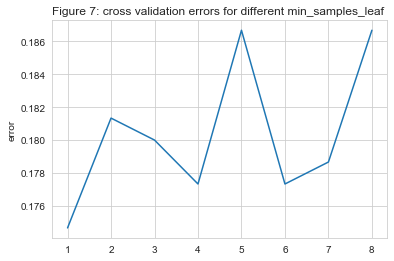

In [42]:
# Using scikit-learn's KFold to get cross-validation scores for different min_samples_leaf 
# (The minimum number of samples required to be at a leaf node.) values in RFC-model

n_fold = 10
models = []
averages = []
min_samples_leaf_list = [1,2,3,4,5,6,7,8]

for j in min_samples_leaf_list:
    models.append(RandomForestClassifier(min_samples_leaf=j,random_state=42))


misclassifications = np.zeros((n_fold,len(models)))
cv = KFold(n_splits=n_fold,random_state=42, shuffle=True)

for i, (train_index,val_index) in enumerate(cv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    for m in range(np.shape(models)[0]):
        model = models[m]
        model.fit(X_train,y_train)
        predictions = model.predict(X_val)
        misclassifications[i,m] = np.mean(predictions != y_val)

for j in range(len(models)):
    #print(np.mean(misclassifications[:,j]))
    averages.append(np.mean(misclassifications[:,j]))

plt.plot(min_samples_leaf_list,averages)
plt.title('Figure 7: cross validation errors for different min_samples_leaf ');
plt.ylabel('error')
plt.grid(b=True)
plt.show()



### Updated Model KFold Cross-Validation score

In [13]:
#Applying the best parameters in a final model

n_fold=10
misclassifications = np.zeros((n_fold,1))
cv = KFold(n_splits=n_fold,random_state=42, shuffle=True)

for i, (train_index,val_index) in enumerate(cv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
   
    model = RandomForestClassifier(n_estimators=500, criterion='gini',max_features='sqrt',min_samples_split=10, min_samples_leaf=1,random_state=1)
    model.fit(X_train,y_train)
    predictions = model.predict(X_val)
    misclassifications[i] = np.mean(predictions == y_val)


print(np.mean(misclassifications))

0.828


### Feature Selection using SelectFromModel and feature_importances_ from RFC model

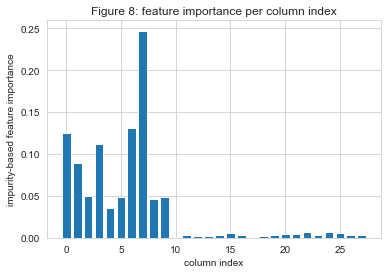

In [50]:
from sklearn.feature_selection import SelectFromModel

# Create and fit our final RFC model
rclf = RandomForestClassifier(n_estimators=500, criterion='gini',max_features='sqrt',min_samples_split=10, min_samples_leaf=1,random_state=1)
rclf = rclf.fit(X, y)

# Selecting features based on importance weights
model = SelectFromModel(rclf, prefit=True,threshold='median')
X_new = model.transform(X)

# Model.transform(X) outputs a numpy array. Since we want to keep working with dataframes we output the features that were 
# selected with the get_support method.
features = model.get_support(indices=False)
features = features.astype(int)

#Create a list of the feature_indices that survive the threshold
feature_indices = []
for i in range(len(features)):
    if features[i]==1:
        feature_indices.append(i)

plt.bar(range(len(rclf.feature_importances_)),rclf.feature_importances_)
plt.title('Figure 8: feature importance per column index')
plt.ylabel('impurity-based feature importance')
plt.xlabel('column index')
plt.grid(b=True)
plt.show()

In [59]:
n_fold=10
misclassifications = np.zeros((n_fold,1))
cv = KFold(n_splits=n_fold,random_state=42, shuffle=True)

X_feature_reduction = X.iloc[:, feature_indices]

for i, (train_index,val_index) in enumerate(cv.split(X_feature_reduction)):
    X_train, X_val = X_feature_reduction.iloc[train_index], X_feature_reduction.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
   
    model = RandomForestClassifier(n_estimators=500, criterion='gini',max_features='sqrt',min_samples_split=10, min_samples_leaf=1,random_state=1)
    model.fit(X_train,y_train)
    predictions = model.predict(X_val)
    misclassifications[i] = np.mean(predictions == y_val)


print(np.mean(misclassifications))

0.8306666666666667


### Cross-validation with KFold (k=20) to compare my model to the model of the other groupmembers:

In [64]:
# The problem is the following:
#
# We wish to evaluate each model in a uniform manner using cross validation.
# In order to do this, we need to refit and rescore like we did in our parameter search, but for the chosen parameter.
#
# input:
# model - an instance of the object on which we run the fit and score functions (these have no common name in sklearn unfortunately)
# X - our particular processed version of the X part of the training data
# y - our particular processed version of the label
# splits - how many splits to perform (optional)
#
# output: a comparable cross-validated score for our chosen model.
#
#
# Example usage:
#
# 1. I have processed the data in some way to produce X and y, which preserve the original order in the data file. These are called X and y respectively.
#
# 2. I have used some sort of voodoo to conclude that a certain set of parameters is the best set.
#
# 3. The parameters correspond to, in this case, KNeighborsClassifier(n_neighbors = 1337, algorithm = "brute")
#
# I therefore run the line:
#
# print(cross_validate(KNeighborsClassifier(n_neighbors = 1337, algorithm = "brute"), X,y))
#
# in the appropriate notebook, and it will print a comparable cross validated score which can be compared to Loves, Alexis' or Rafaela's best comparable score.

X_feature_reduction = X.iloc[:, feature_indices]

def cross_validate(model,X,y, splits = 20):
    kf = KFold(n_splits = splits)
    correct_count = 0
    attempts = 0
    
    for training, testing in kf.split(X):
        model.fit(X[training],y[training])
        prediction = model.predict(X[testing])
        correct_count += len([None for (i, j) in zip(prediction, y[testing]) if i == j])
        attempts += len(prediction)

    return correct_count/attempts

final_model_rfc = RandomForestClassifier(n_estimators=500, criterion='gini',max_features='sqrt',min_samples_split=10,random_state=1)
cross_validate(final_model_rfc, X_feature_reduction.to_numpy(), y.to_numpy())

0.8293333333333334

### Training model on all training data and outputting prediction string

In [65]:

X_feature_reduction = X.iloc[:, feature_indices]
songs_to_classify_feature_reduction = songs_to_classify.iloc[:, feature_indices]

model_rfc = RandomForestClassifier(n_estimators=500, criterion='gini',max_features='sqrt',min_samples_split=10, min_samples_leaf=1,random_state=1)
model_rfc.fit(X_feature_reduction,y)
predictions = model_rfc.predict(songs_to_classify_feature_reduction)
output = ''.join([str(int(p)) for p in predictions])
print(output)

11100001011110011000101111111001110111101000110000000110100110000100100111010000101111110011110011111010011010110011011011110001011011011101111111101010101001111010010101111010101110101010101111111000
